In [256]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
from itertools import combinations as cmbs
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import itertools
from scipy import stats
%config InlineBackend.figure_format='retina'
import statsmodels.stats.multitest as smsm

In [285]:
expt_no = 4
#df_conds = pd.read_csv(f'./experiment{expt_no}/NSTEVENS-2.csv')
#df = pd.read_csv(f'./experiment{expt_no}/RESULTS_STUDENTS_2022-01-20.csv')
df = pd.read_csv(f'./experiment{expt_no}/STUDENTS_round4_result_combined.csv')


In [286]:
df

,Prev.Length,Match.Score,Prev.Type,Tile.Size,Browse.Time
0,75,70,TT,0.2,9.011686
1,75,80,TT,0.2,11.429129
2,80,65,TT,0.2,11.550778
3,80,75,TT,0.2,10.064205
4,75,70,TT,0.2,8.757678
...,...,...,...,...,...
1495,80,70,TT,0.2,10.040951
1496,80,80,TT,0.2,10.906982
1497,80,60,TT,0.2,13.907826
1498,80,70,TT,0.2,10.790122


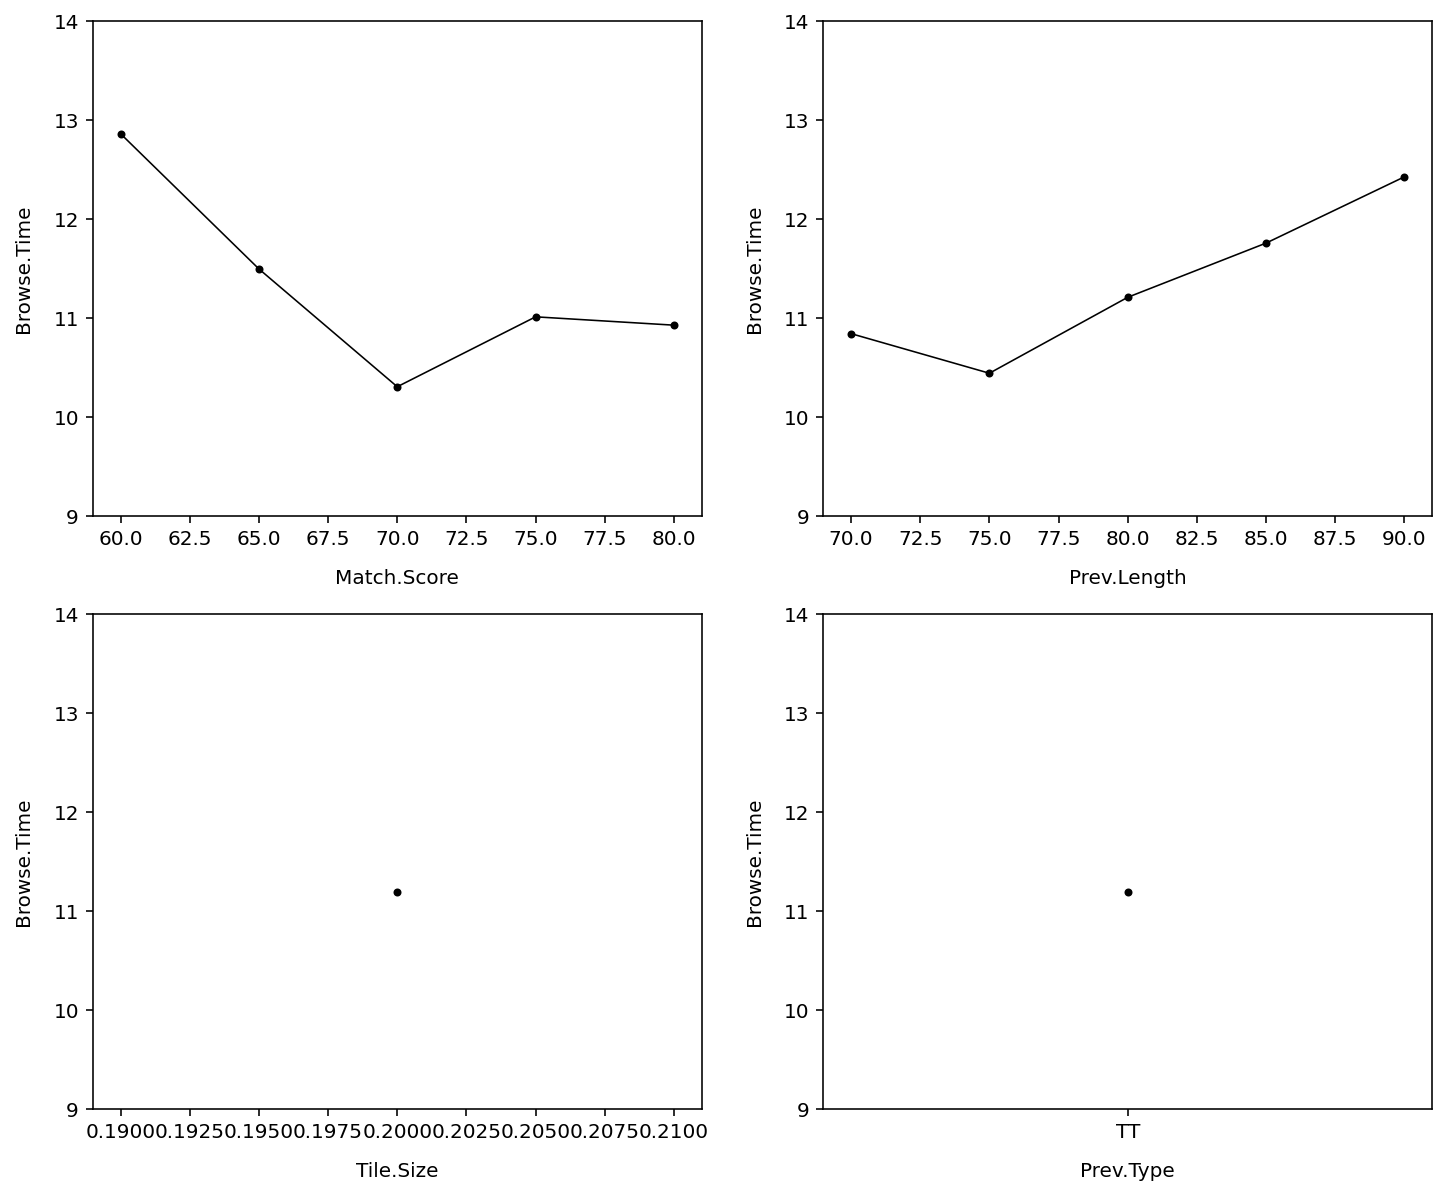

In [287]:
def ME_plot(df, x, y, ax, ymin, ymax):
    me = df.groupby(x).mean()[y]
    ax.plot(me.index, me.values, color = 'black', lw = 0.8, marker = '.')
    ax.set_xlabel(f'{x}', labelpad = 10)
    ax.set_ylabel(f'{y}', labelpad = 10)
    ax.set_ylim(ymin, ymax)

fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax = ax.flatten()
xs = ['Match.Score', 'Prev.Length', 'Tile.Size', 'Prev.Type']
y = 'Browse.Time'
#loop for finding the min and max
vals = []
for col in xs:
    vals += list(df.groupby(col).mean()[y].values)
ymin, ymax = floor(min(vals)) - 1 , ceil(max(vals)) + 1

#loop for plotting
for i, x in enumerate(xs):
    ME_plot(df, x, y, ax[i], ymin, ymax)
plt.show()

#show only relevant xticks

IndexError: list index out of range

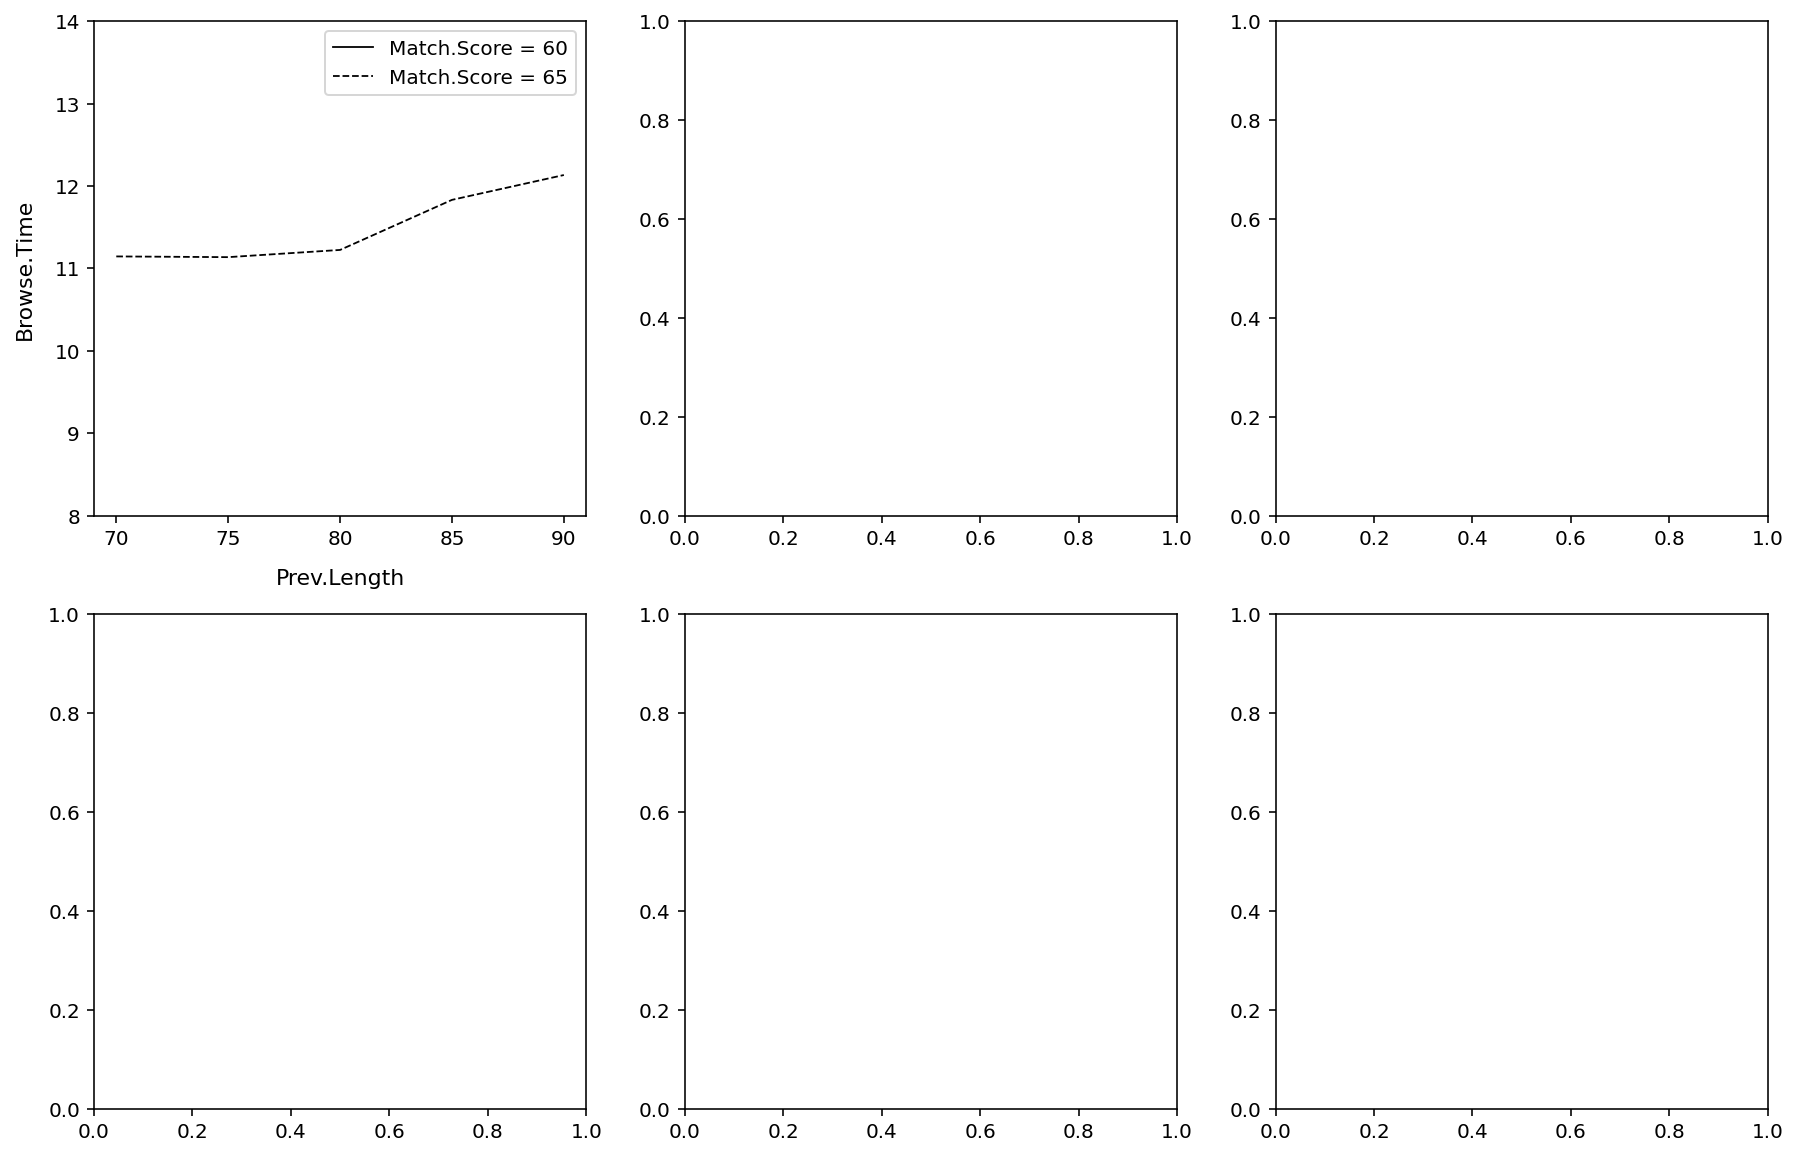

In [288]:
#x = ['Match.Score', 'Prev.Length']
y = 'Browse.Time'
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
ax = ax.flatten()

def IE2_plot(df, x, y, ax):
    ie2 = df.groupby(x).mean()[y]
    ie2 = ie2.reset_index()
    linestyles = ['solid', 'dashed']
    for i, val in enumerate(ie2[x[0]].unique()):
        plot_df = ie2[ie2[x[0]] == val]
        ax.plot(plot_df.iloc[:,1], plot_df.iloc[:, 2], color = 'black', 
                ls = linestyles[i], lw = 0.9, label = f'{x[0]} = {val}')
        ax.set_xlabel(x[1], labelpad = 10, size = 11)
        ax.set_ylabel(y, labelpad = 10, size = 11) 
        ax.set_ylim(ymin, ymax)
        ax.legend()

#loop for finding the min and max
vals = []
for col in cmbs(xs, 2):
    vals += list(df.groupby(list(col)).mean()[y].values)
ymin, ymax = floor(min(vals)) - 1 , ceil(max(vals)) + 1

# loop for plotting
for i, x in enumerate(cmbs(xs, 2)):
    IE2_plot(df, list(x), y, ax[i])

plt.tight_layout()
plt.show()

### show only relevant xticks

## Building the required Pivot table and conditions dictionary

In [289]:
df.columns = ['Prev_Length', 'Match_Score', 'Tile_Size', 'Prev_Type', 'Browse_Time']
merged_df = df.groupby(['Prev_Length', 'Prev_Type', 'Match_Score', 'Tile_Size'], as_index = False)\
              .aggregate(["mean", "var"]).reset_index()
merged_df['Browse_Time_mean'] = merged_df['Browse_Time']['mean']
merged_df['Browse_Time_var'] = merged_df['Browse_Time']['var']
merged_df = merged_df.drop('Browse_Time',axis = 1).sort_values("Browse_Time_mean")

active_df = merged_df[merged_df['Tile_Size'] != 0.5].copy()
#active_df = active_df.drop(columns='Tile_Size')
active_df['conditions'] = [f'condition{i+1}' for i in range(len(active_df))]
active_df.set_index('conditions', inplace = True, drop = False)
conditions_dict = {active_df.loc[f'condition{i+1}','conditions'][0] : list(active_df.iloc[i,:4])for i in range(len(active_df))}
active_df


/Users/ashwanirajan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Prev_Length,Prev_Type,Match_Score,Tile_Size,Browse_Time_mean,Browse_Time_var,conditions
,,,,,,,
conditions,,,,,,,
condition1,75,0.2,75,TT,9.845808,1.126548,condition1
condition2,75,0.2,70,TT,10.230515,0.890569,condition2
condition3,80,0.2,75,TT,10.271900,1.141436,condition3
condition4,80,0.2,70,TT,10.376416,0.680117,condition4
condition5,70,0.2,75,TT,10.535306,1.045057,condition5
condition6,75,0.2,80,TT,10.546644,0.916828,condition6
condition7,75,0.2,65,TT,11.137689,0.959594,condition7
condition8,70,0.2,65,TT,11.146524,0.852596,condition8


In [290]:
active_df.to_csv(f'./experiment{expt_no}/active_df.csv')

In [291]:
def get_data_from_conds(lst_conds, conditions_dict, df):

    frames = [] 
    for i, c in enumerate(lst_conds):
        fltr = (df['Prev_Length'] == conditions_dict[c][0]) & \
                      (df['Prev_Type'] == conditions_dict[c][1]) & \
                     (df['Match_Score'] == conditions_dict[c][2]) & \
                    (df['Tile_Size'] == conditions_dict[c][3])
        df_ = df[fltr].copy()
        df_['conditions'] = c
        frames.append(df_)

    result = pd.concat(frames)
    return result   

In [292]:

gt_df = get_data_from_conds(['condition1', 'condition2', 'condition3'], conditions_dict, df)
def GateKeeper(gt_df):
    model = smf.ols('Browse_Time ~ C(conditions)', data = gt_df).fit()
    summary = pd.read_html(model.summary().tables[0].as_html(),header=0,index_col=0)[0]
    return summary
    

In [293]:
model = smf.ols('Browse_Time ~ C(Prev_Length)+C(Match_Score)+C(Tile_Size)+C(Prev_Type)', data = gt_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Browse_Time   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5.244
Date:                Fri, 21 Jan 2022   Prob (F-statistic):            0.00578
Time:                        23:21:12   Log-Likelihood:                -431.90
No. Observations:                 300   AIC:                             869.8
Df Residuals:                     297   BIC:                             880.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.2305      0.103     99.704      0.000      10.029      10.432
C(Prev_Length)[T.80]     0.4261      0.145      2.936      0.004       0.141       0.712
C(Match_Score)[T.75]    -0.3847      0.145     -2.651      0.008      -0.670      -0.099
==============================================================================
Omnibus:                        1.287   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.222
Skew:                           0.022   Prob(JB):                        0.543
Kurtosis:                       2.691   Cond. No.                         4.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [294]:
gt_df

,Prev_Length,Match_Score,Tile_Size,Prev_Type,Browse_Time,conditions
405,75,75,TT,0.2,11.453359,condition1
413,75,75,TT,0.2,10.589273,condition1
421,75,75,TT,0.2,10.051019,condition1
429,75,75,TT,0.2,9.058226,condition1
437,75,75,TT,0.2,8.963615,condition1
...,...,...,...,...,...,...
383,80,75,TT,0.2,8.896315,condition3
387,80,75,TT,0.2,10.858652,condition3
391,80,75,TT,0.2,11.952905,condition3
395,80,75,TT,0.2,11.643942,condition3


In [295]:
GateKeeper(gt_df)

,Browse_Time,R-squared:,0.034
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.02800
Method:,Least Squares,F-statistic:,5.24400
Date:,"Fri, 21 Jan 2022",Prob (F-statistic):,0.00578
Time:,23:21:12,Log-Likelihood:,-431.90000
No. Observations:,300,AIC:,869.80000
Df Residuals:,297,BIC:,880.90000
Df Model:,2,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [296]:
important_conditions = ['condition1', 'condition2', 'condition3', 'condition4']
n1 = 100
n2 = 100

def all_test_results(important_conditions,n1,n2,active_df,conditions_dict):
    all_hypothesis = []
    for i in itertools.combinations(important_conditions, 2):
        lst =[]
        lst.append(f'{i[0]} vs {i[1]}')
        lst.append(f'Ha : mean_{i[0]} < mean_{i[1]}')
        lst.append(f'{conditions_dict[i[0]]} vs {conditions_dict[i[1]]}')
        mean1 = active_df.loc[i[0],"Browse_Time_mean"][0]
        lst.append(mean1)
        mean2 = active_df.loc[i[1],"Browse_Time_mean"][0]
        lst.append(mean2)
        sigma1 = active_df.loc[i[0],"Browse_Time_var"][0]
        sigma2 = active_df.loc[i[1],"Browse_Time_var"][0]
        t = sigma1/sigma2
        
        if t>1:
            pv = 1 - stats.f.cdf(t, dfn=n1-1, dfd=n2-1) + stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1)
        else:
            pv = stats.f.cdf(t, dfn=n1-1, dfd=n2-1) + 1 - stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1)
        
        if pv > 0.05:
            lst.append(False)
            df = min(n1,n2)-1
            T, p_val = stats.ttest_ind_from_stats(mean1, np.sqrt(sigma1), n1, mean2, np.sqrt(sigma2), n2, \
                                               equal_var=False, alternative='less')
            lst.append(T)
            lst.append(p_val)

        else:
            lst.append(True)
            df = n1 + n2 - 2
            sigma = np.sqrt(((n1-1)*sigma1**2 + (n2-1)*sigma2**2)/(n1+n2-2))
            T, p_val = stats.ttest_ind_from_stats(mean1, np.sqrt(sigma1), n1, mean2, np.sqrt(sigma2), n2, \
                                               equal_var=True, alternative='less')
            lst.append(T)
            lst.append(p_val)

        all_hypothesis.append(lst)
    
    results_df = pd.DataFrame(all_hypothesis, columns = ['conditions', 'Ha','condition_values','mean1','mean2','sigma1=sigma2?','T-stat', 'p-val'])
    p = results_df['p-val']
    res, padj, alphSid, alphBonf = smsm.multipletests(pvals = p, alpha = 0.05, method = "bonferroni")
    results_df["Bonferroni corrections"] = padj
    results_df["Should I reject H0?"] = res
    return results_df

In [297]:
results = all_test_results(important_conditions,n1,n2,active_df,conditions_dict)

In [298]:
results

,conditions,Ha,condition_values,mean1,mean2,sigma1=sigma2?,T-stat,p-val,Bonferroni corrections,Should I reject H0?
0,condition1 vs condition2,Ha : mean_condition1 < mean_condition2,"[75, 0.2, 75, 'TT'] vs [75, 0.2, 70, 'TT']",9.845808,10.230515,False,-2.708726,0.003677,0.022062,True
1,condition1 vs condition3,Ha : mean_condition1 < mean_condition3,"[75, 0.2, 75, 'TT'] vs [80, 0.2, 75, 'TT']",9.845808,10.271900,False,-2.829333,0.002572,0.015435,True
2,condition1 vs condition4,Ha : mean_condition1 < mean_condition4,"[75, 0.2, 75, 'TT'] vs [80, 0.2, 70, 'TT']",9.845808,10.376416,True,-3.947621,0.000055,0.000329,True
3,condition2 vs condition3,Ha : mean_condition2 < mean_condition3,"[75, 0.2, 70, 'TT'] vs [80, 0.2, 75, 'TT']",10.230515,10.271900,False,-0.290324,0.385938,1.000000,False
4,condition2 vs condition4,Ha : mean_condition2 < mean_condition4,"[75, 0.2, 70, 'TT'] vs [80, 0.2, 70, 'TT']",10.230515,10.376416,False,-1.164163,0.122892,0.737352,False
5,condition3 vs condition4,Ha : mean_condition3 < mean_condition4,"[80, 0.2, 75, 'TT'] vs [80, 0.2, 70, 'TT']",10.271900,10.376416,True,-0.774392,0.219811,1.000000,False


In [232]:
results.to_csv(f'./experiment{expt_no}/results.csv')

## comparing with previous best condition:
    

In [233]:
df_prev = pd.read_csv(f'./experiment{expt_no-1}/active_df.csv', index_col=0)
prev_data1 = df_prev[df_prev['conditions'] == "condition1"]
#prev_data2 = df_prev[df_prev['conditions'] == "condition2"]

In [234]:
prev_data1

,Prev_Length,Prev_Type,Match_Score,Tile_Size,Browse_Time_mean,Browse_Time_var,conditions
condition1,75.0,0.2,75.0,TT,9.845808,1.126548,condition1


In [235]:
def compare_with_previous(prev_data, active_df ,n1, n2):
    lst =[]
    lst.append('current_condition1 < prev_condition1')
    mean1 = active_df.loc['condition1',"Browse_Time_mean"][0]
    lst.append(mean1)
    mean2 = prev_data.loc['condition1',"Browse_Time_mean"]
    lst.append(mean2)
    sigma1 = active_df.loc['condition1',"Browse_Time_var"][0]
    sigma2 = prev_data.loc['condition1',"Browse_Time_var"]
    
    t = sigma1/sigma2

    if t>1:
        pv = 1 - stats.f.cdf(t, dfn=n1-1, dfd=n2-1) + stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1)
    else:
        pv = stats.f.cdf(t, dfn=n1-1, dfd=n2-1) + 1 - stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1)

    if pv > 0.05:
        lst.append(False)
        df = min(n1,n2)-1
        T, p_val = stats.ttest_ind_from_stats(mean1, np.sqrt(sigma1), n1, mean2, np.sqrt(sigma2), n2, \
                                           equal_var=False, alternative='less')
        lst.append(T)
        lst.append(p_val)

    else:
        lst.append(True)
        df = n1 + n2 - 2
        sigma = np.sqrt(((n1-1)*sigma1**2 + (n2-1)*sigma2**2)/(n1+n2-2))
        T, p_val = stats.ttest_ind_from_stats(mean1, np.sqrt(sigma1), n1, mean2, np.sqrt(sigma2), n2, \
                                           equal_var=True, alternative='less')
        lst.append(T)
        lst.append(p_val)

    results_df = pd.DataFrame(lst, index = ['Ha','current_mean','prev_mean','sigma1=sigma2?','T-stat', 'p-val'])
    

    return results_df

In [236]:
current_vs_prev = compare_with_previous(prev_data1, active_df ,100, 100)
current_vs_prev

,0
Ha,current_condition1 < prev_condition1
current_mean,9.845808
prev_mean,9.845808
sigma1=sigma2?,False
T-stat,0.0
p-val,0.5


In [237]:
current_vs_prev.to_csv(f'./experiment{expt_no}/current_vs_prev1.csv')

confidence interval

In [240]:
gt_df1 = get_data_from_conds(['condition1'], conditions_dict, df)

In [242]:
gt_df1

,Prev_Length,Match_Score,Tile_Size,Prev_Type,Browse_Time,conditions
405,75,75,TT,0.2,11.453359,condition1
413,75,75,TT,0.2,10.589273,condition1
421,75,75,TT,0.2,10.051019,condition1
429,75,75,TT,0.2,9.058226,condition1
437,75,75,TT,0.2,8.963615,condition1
...,...,...,...,...,...,...
1165,75,75,TT,0.2,10.472651,condition1
1173,75,75,TT,0.2,10.484886,condition1
1181,75,75,TT,0.2,7.608153,condition1
1189,75,75,TT,0.2,8.063136,condition1


In [247]:
welch_var = gt_df1['Browse_Time'].var(ddof = 1)

In [248]:
T_critical = stats.t.ppf((1-0.05/2), 99)
print("T critical =", T_critical)

T critical = 1.9842169515086827


In [250]:
b = abs(9.845808) + T_critical*welch_var/np.sqrt(100)
a = abs(9.845808) - T_critical*welch_var/np.sqrt(100)
print(f'Confidence Interval = ({a}, {b})')

Confidence Interval = (9.622276340323937, 10.069339659676062)


In [42]:
current_vs_prev2 = compare_with_previous(prev_data2, active_df ,100, 100)
current_vs_prev2

KeyError: 'condition1'